# Linear Regression 2

*Author: Evan Carey*

*Copyright 2017, BH Analytics, LLC*

## Overview

The purpose of this section is to extend your understanding of linear regression. In this module, we will be covering the concepts of non-linearity in a model, confounding, interaction, and model selection. 

## Libraries

In [1]:
## Import Modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import seaborn as sns
import textwrap

In [2]:
## Enable inline plotting for graphics
%matplotlib inline

## Set print options
pd.options.display.max_rows = 10

In [3]:
print(textwrap.fill(sys.version),'\n')
print("Pandas version: {0}".format(pd.__version__),'\n')
print("Matplotlib version: {0}".format(matplotlib.__version__),'\n')
print("Numpy version: {0}".format(np.__version__),'\n')
print("Statsmodels version: {0}".format(statsmodels.__version__))

3.5.2 |Anaconda 4.3.1 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC
v.1900 64 bit (AMD64)] 

Pandas version: 0.19.2 

Matplotlib version: 2.0.0 

Numpy version: 1.11.3 

Statsmodels version: 0.6.1


## Check your working directory

Subsequent sessions may require you to identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [4]:
# Working Directory
import os
print("My working directory:\n" + os.getcwd())
# Set Working Directory (if needed)
os.chdir(r"C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs")
print("My new working directory:\n" + os.getcwd())

My working directory:
C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs\Intermediate_python\course_downloads\intermediate_course_download\notebooks
My new working directory:
C:\Users\evan\Dropbox\BH_Katie_Share\Goldman_Sachs


## Motivating Example: Sales data

For this section, we will use some sales data as a motivating example. This is a simulated dataset with both a binary outcome (sale) and a continuous outcome (sale_amount). We will focus on a subset of the data with positive sale amounts. First, we should import the data. 

In [5]:
## import data
sale_df = pd.read_csv(r'data\Simulated_sales_data\customer_sales1.csv')

In [6]:
sale_df

customer_id sale  sale_amount  region  age  gender activity  \
0          100000   No     0.000000      35   62    Male      Med   
1          100001  Yes   884.478029      13   71  Female     High   
2          100002   No     0.000000      23   53    Male     High   
3          100003   No     0.000000      12   60    Male      Med   
4          100004  Yes   243.937661      44   62    Male      Med   
...           ...  ...          ...     ...  ...     ...      ...   
7995       109995   No     0.000000       5   57    Male      Low   
7996       109996  Yes   722.514200      20   75  Female     High   
7997       109997  Yes   136.011300      11   58    Male      Low   
7998       109998  Yes   357.461500      49   64    Male      Med   
7999       109999  Yes    19.834360      30   46    Male      Med   

      marketing_exposure         x1         x2          x3  x4  x5  \
0                      6  73.674643   8.263063   93.879407  10   1   
1                      5  49.195984  11.925201   72.862514   7   2   
2                      6  49.868492  10.932390  128.150580  12   2   
3                      7  42.563154   9.725310  126.266391  11   1   
4                     11  45.035440   9.941171  108.037634   9   3   
...                  ...        ...        ...         ...  ..  ..   
7995                   4  70.116000  10.037210   87.654960  13   0   
7996                   1  38.415910  14.850920  129.327200  12   1   
7997                   6  49.014800  10.558640   97.097510  15   2   
7998                   7  52.215140   8.967199   59.178810  11   0   
7999                   4  21.092390   9.611086  106.878500   9   5   

      num_accounts current_customer  income  
0                0               No      78  
1                2               No      66  
2                1              Yes      86  
3                0              Yes      70  
4                0               No      59  
...            ...              ...     ...  
7995             1               No      59  
7996             0               No      74  
7997             0              Yes      54  
7998             0              Yes      59  
7999             0              Yes      59  

[8000 rows x 16 columns]

In [7]:
## Subset down to only the rows with sales
sub_sale_df = sale_df.loc[sale_df.sale_amount>0,].copy()

In [8]:
print(sub_sale_df.describe())

         customer_id  sale_amount       region          age  \
count    4765.000000  4765.000000  4765.000000  4765.000000   
mean   104998.994963   418.010294    25.786779    60.136831   
std      2899.603126   308.548414    14.122540    11.175953   
min    100001.000000    10.000000     1.000000    21.000000   
25%    102446.000000   185.226800    14.000000    53.000000   
50%    104991.000000   357.894854    26.000000    60.000000   
75%    107498.000000   582.188400    38.000000    68.000000   
max    109999.000000  2111.991000    50.000000    98.000000   

       marketing_exposure           x1           x2           x3           x4  \
count         4765.000000  4765.000000  4765.000000  4765.000000  4765.000000   
mean             4.706401    49.926427     9.951681   102.195231     9.968730   
std              2.584599    10.117197     2.024681    19.519291     3.082423   
min              0.000000    14.596822     2.598669    31.452700     2.000000   
25%              3.000000  

## Examine the Distribution of the Outcome

We can start by looking at the distribution of the outcome to get a sense of the data.

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


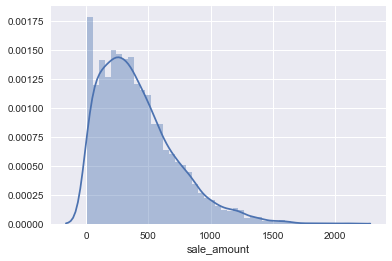

In [9]:
sns.distplot(sub_sale_df.sale_amount)

This looks like a typical strictly positive distribution. Since it is not possible to have a negative sale price, we see a bit of skew, with most of the data focused on lower priced items, and a smaller amount of data in the higher priced items. 

This data is not normally distributed, however, we can still use linear regression to make inference on the mean due to the central limit theorem. In subsequent modules we will consider different forms of general linear regression that may also be appropriate for this data. 

Our target of inference here is the sample mean, so we are interested in getting the best estimate of the sample mean, given the potential predictors. We can start but just calculating the sample mean as an initial estimator:

In [10]:
sub_sale_df.sale_amount.mean()

418.01029406912784

In [11]:
mod0 = smf.ols('sale_amount ~ 1', data=sub_sale_df).fit()
print(mod0.summary())

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\regression\linear_model.py:1191: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 18 May 2017   Prob (F-statistic):                nan
Time:                        14:44:18   Log-Likelihood:                -34073.
No. Observations:                4765   AIC:                         6.815e+04
Df Residuals:                    4764   BIC:                         6.815e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    418.0103      4.470     93.518      0.0

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Age by Sale Amount

We can investigate the relationship between age and mean sale amount. If we simply include age in the model as a linear predictor, we are assuming a linear relationship between these variables. Is that appropriate here?

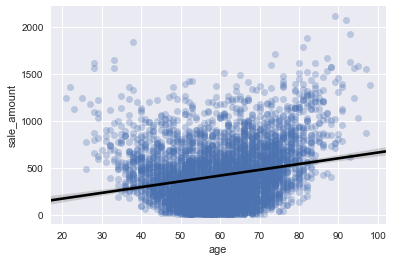

In [12]:
sns.regplot(x='age',
            y='sale_amount',
            data=sub_sale_df,
            scatter_kws={'alpha':0.3},
            line_kws={'color': 'black'})

It looks like there is a non-linear relationship between age and the sale amount. In this case, we may be able to approximate it using a simply polynomial like this:

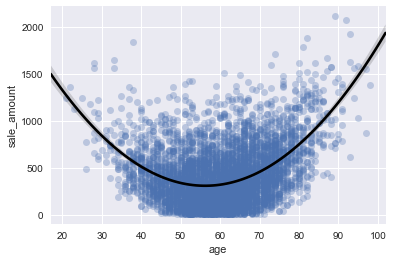

In [13]:
sns.regplot(x='age',
            y='sale_amount',
            data=sub_sale_df,
            scatter_kws={'alpha':0.3},
            line_kws={'color': 'black'},
            order=2)

This looks like a good fit to the data. We can fit this in the linear model like so:

In [14]:
mod1 = smf.ols('sale_amount ~ age + I(age**2)',
               data=sub_sale_df).fit()
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     768.5
Date:                Thu, 18 May 2017   Prob (F-statistic):          5.77e-290
Time:                        14:44:19   Log-Likelihood:                -33407.
No. Observations:                4765   AIC:                         6.682e+04
Df Residuals:                    4762   BIC:                         6.684e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    2763.6187     80.383     34.381      

The p-values for the age and age-squared term indicate that this is a reasonable fit for the model. However, there is clearly still a large amount of variation left-over in this model (as evidenced by the errors around the predicted sample mean). 

## Non-Linearity: Marketing Exposure

We may also be interested in estimating the effect of marketing exposure on the sale amount. Let's begin by visualizing the relationship between these variables alone:

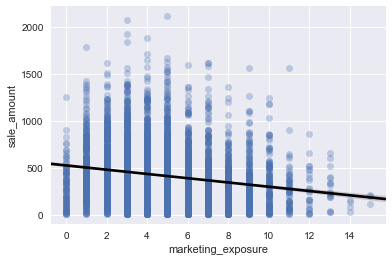

In [15]:
sns.regplot(x='marketing_exposure',
            y='sale_amount',
            data=sub_sale_df,
            scatter_kws={'alpha':0.3},
            line_kws={'color': 'black'})

It looks like there is an overall negative effect of marketing exposure! The more marketing exposure someone recieves, the less likely they are to buy the product?!? We will find this is not the case in the end, but let's continue with this pairwise investigation for now. 

In [16]:
mod2= smf.ols('sale_amount ~ marketing_exposure',
               data=sub_sale_df).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     178.5
Date:                Thu, 18 May 2017   Prob (F-statistic):           5.36e-40
Time:                        14:44:19   Log-Likelihood:                -33985.
No. Observations:                4765   AIC:                         6.797e+04
Df Residuals:                    4763   BIC:                         6.799e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            524.7958      9

## Non-Linearity: Splines and Marketing Exposure

We can further examine this relationship by looking at a non-linear fit for this data. 

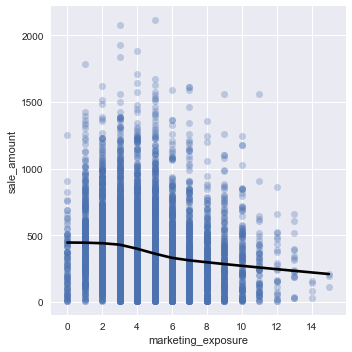

In [17]:
sns.lmplot(x='marketing_exposure',
           y='sale_amount',
           data=sub_sale_df,
           scatter_kws={'alpha':0.3},
           line_kws={'color': 'black'},
           lowess=True)

The non-linear fit gives us a similar answer as the linear fit. We can fit a flexible line in the context of regression by using splines. The general idea is that we split the data up into regions, then fit a polynomial within each region that connects. It is pretty straightforward to fit a spline model using statsmodels and patsy, but the output can be difficult to understand. We need to define the number of knots (the place we will split intp different regions). We do this by defining the degress of freedom. 

In [18]:
mod3= smf.ols('sale_amount ~ bs(marketing_exposure,3)',
               data=sub_sale_df).fit()
print(mod3.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     69.25
Date:                Thu, 18 May 2017   Prob (F-statistic):           7.88e-44
Time:                        14:44:20   Log-Likelihood:                -33971.
No. Observations:                4765   AIC:                         6.795e+04
Df Residuals:                    4761   BIC:                         6.798e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept       

We can visualize the spline we just fit by running some predictions through the model like so:

In [19]:
df_temp = pd.DataFrame({'marketing_exposure':np.arange(14)})
df_temp['pred_sale_amount'] = mod3.predict(df_temp)

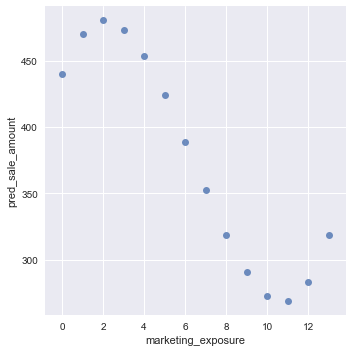

In [20]:
sns.lmplot(x='marketing_exposure',
           y='pred_sale_amount',
           data=df_temp,
           fit_reg=False)

We can specify the degree of the polynomials used, by saying degree == 1, we are asking for straight lines in each region. 

In [21]:
mod4= smf.ols('sale_amount ~ bs(marketing_exposure,3,degree=1)',
               data=sub_sale_df).fit()
print(mod4.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     73.86
Date:                Thu, 18 May 2017   Prob (F-statistic):           1.10e-46
Time:                        14:44:20   Log-Likelihood:                -33965.
No. Observations:                4765   AIC:                         6.794e+04
Df Residuals:                    4761   BIC:                         6.796e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

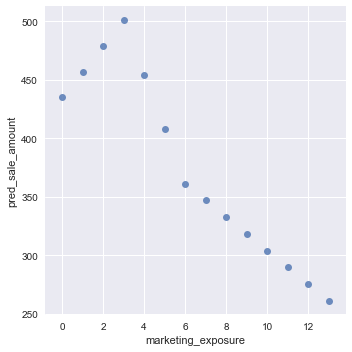

In [22]:
df_temp = pd.DataFrame({'marketing_exposure':np.arange(14)})
df_temp['pred_sale_amount'] = mod4.predict(df_temp)
sns.lmplot(x='marketing_exposure',
           y='pred_sale_amount',
           data=df_temp,
           fit_reg=False)

## Interaction Effects: Gender by Marketing Exposure

This is an odd relationship...the more marketing exposure, the less sale amount? Perhaps there is something else going on here. Gender may also play a role...let's examine the relationship between marketing exposure and sale amount for each gender seperately. 

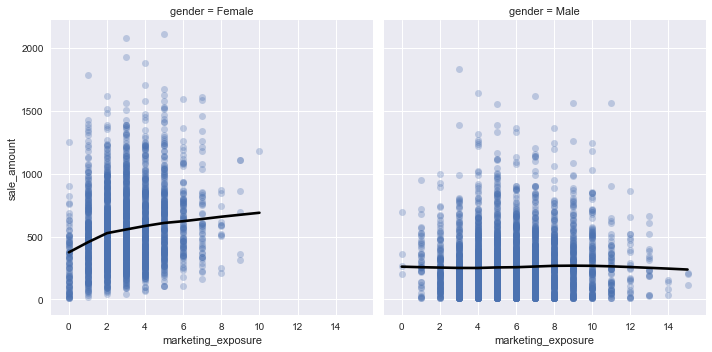

In [23]:
sns.lmplot(x='marketing_exposure',
           y='sale_amount',
           data=sub_sale_df,
           scatter_kws={'alpha':0.3},
           line_kws={'color': 'black'},
           lowess=True,
          col='gender')


This result looks very different than what we just found! We are seeing that there is a positive effect of marketing exposure in females that seems to plateau...but there is no effect in males. This is plausible, but how would we fit this in our model? We do this by including an interaction term between these variables. The interacton term is denoted by the * sign. It is a literal multiplication of the two terms together. We will start by adding gender into the model, then also adding the interaction so we have a comparison. 

In [24]:
## Add gender into the model, no interaction yet
mod5 = smf.ols('sale_amount ~ bs(marketing_exposure,3,degree=1) + gender',
               data=sub_sale_df).fit()
print(mod5.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     347.1
Date:                Thu, 18 May 2017   Prob (F-statistic):          1.50e-262
Time:                        14:44:21   Log-Likelihood:                -33463.
No. Observations:                4765   AIC:                         6.694e+04
Df Residuals:                    4760   BIC:                         6.697e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------

In [25]:
## Add gender into the model with interaction 
mod6 = smf.ols('sale_amount ~ bs(marketing_exposure,3,degree=2) * gender',
               data=sub_sale_df).fit()
print(mod6.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     204.9
Date:                Thu, 18 May 2017   Prob (F-statistic):          1.38e-266
Time:                        14:44:21   Log-Likelihood:                -33445.
No. Observations:                4765   AIC:                         6.691e+04
Df Residuals:                    4757   BIC:                         6.696e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------

Which p-value do we interpret?!? We can compare the models based on the AIC (lower is better), or also by performing a likelihood ratio test since these are nested. 

## Comparing Model Fits: AIC

We can compare using the AIC, which is a penalized likelihood based statistic. In general, the lower the number the better.

In [26]:
print("model-6 AIC: ", mod6.aic)
print("model-5 AIC: ", mod5.aic)

model-6 AIC:  66906.6827393
model-5 AIC:  66936.682765


## Comparing Model Fits: Likelihood Ratio Test

We can use a LRT for models that are “nested”, Meaning one model can be recovered from the other by deleting parameters…

* If they are not nested, we must use AIC.

In [27]:
## Compare Model fits - likelihood
print("model-6 LLF: ", mod6.llf)
print("model-5 LLF: ", mod5.llf)

model-6 LLF:  -33445.3413696
model-5 LLF:  -33463.3413825


In [28]:
## Likelihood ratio test
print(sm.stats.anova_lm(mod5,mod6))

   df_resid           ssr  df_diff       ss_diff         F        Pr(>F)
0    4760.0  3.511239e+08      0.0           NaN       NaN           NaN
1    4757.0  3.484811e+08      3.0  2.642778e+06  12.02523  7.697729e-08


C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In both cases, we see that model 6 is an improvement over model 5. 

## Understanding the Interaction and Spline Terms

If we want to really understand the spline term interaction we just fit, we must again make some predictions to visualize the result of the model terms. 

In [29]:
df_temp = pd.DataFrame({'marketing_exposure':list(range(14))*2,
                        'gender':['Male']*14 + ['Female']*14})

In [30]:
df_temp

gender  marketing_exposure
0     Male                   0
1     Male                   1
2     Male                   2
3     Male                   3
4     Male                   4
..     ...                 ...
23  Female                   9
24  Female                  10
25  Female                  11
26  Female                  12
27  Female                  13

[28 rows x 2 columns]

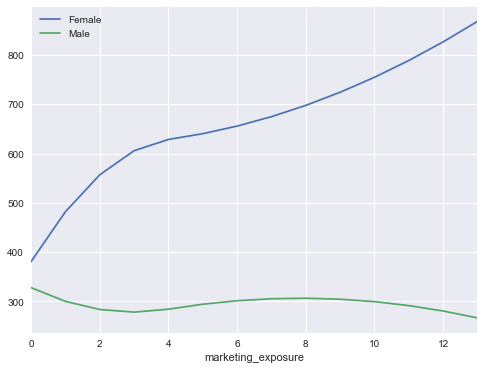

In [31]:
df_temp['pred_sale_amount'] = mod6.predict(df_temp)
fig, ax = plt.subplots(figsize=(8,6))
for label, df in df_temp.groupby('gender'):
    df.plot(x='marketing_exposure',y='pred_sale_amount',ax=ax, label=label)
plt.legend()

## Confounding

Let's examine the relationship between gender and the mean sale amount. We can start with a box plot like this:

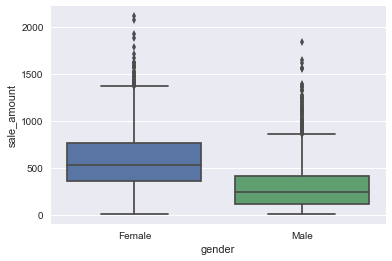

In [32]:
## Compare sale_amount across gender
sns.boxplot(x="gender", 
            y="sale_amount",
            data=sub_sale_df)

It looks like males have a lower average sale amount than females. We can fit a simple linear model with gender as a predictor to estimate the mean difference. 

In [33]:
mod7 = smf.ols('sale_amount ~ gender',
               data=sub_sale_df).fit()
print(mod7.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     1264.
Date:                Thu, 18 May 2017   Prob (F-statistic):          1.09e-245
Time:                        14:44:21   Log-Likelihood:                -33513.
No. Observations:                4765   AIC:                         6.703e+04
Df Residuals:                    4763   BIC:                         6.704e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        580.8623      6.065     95.

We find a highly significant difference here, with males having a lower average sale amount than females. But recall, we also found that age and marketing exposure were associated with sale amount. What if we include all of these variables? 

However, what happens when we include marketing exposure and also age in the model?

In [34]:
mod8 = smf.ols('sale_amount ~ bs(marketing_exposure,3,degree=2) * gender + age + I(age**2)',
               data=sub_sale_df).fit()
print(mod8.summary())

                            OLS Regression Results                            
Dep. Variable:            sale_amount   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     373.2
Date:                Thu, 18 May 2017   Prob (F-statistic):               0.00
Time:                        14:44:21   Log-Likelihood:                -32800.
No. Observations:                4765   AIC:                         6.562e+04
Df Residuals:                    4755   BIC:                         6.568e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------

We now see essentially no effect of gender, with a large p-value! This is odd...it turns out the observed relationship between gender and sale amount was actually just the result of confounding with age and marketing exposure. 